In [1]:
import os
from util import load_pfm

from PIL import Image
import numpy as np
from scipy.ndimage import filters
import matplotlib.pyplot as plt

In [2]:
DATASET_FOLDER = './MiddEval3/trainingQ'

float64 int32
0.499590035044


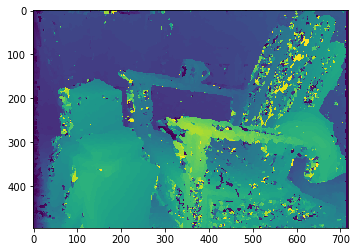

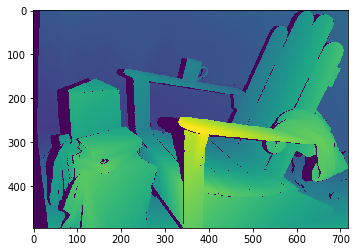

float64 int32
0.517702707473


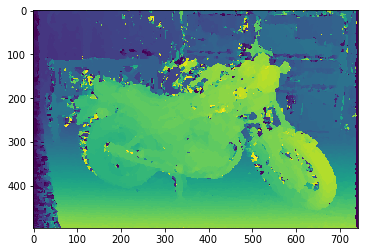

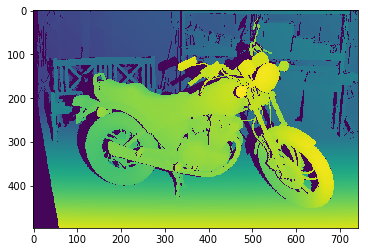

float64 int32
0.404837870184


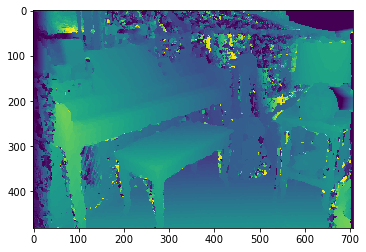

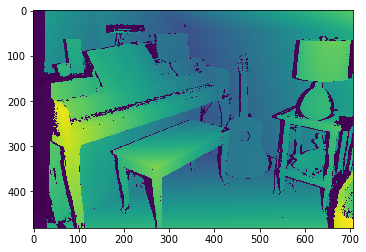

float64 int32
0.51274282909


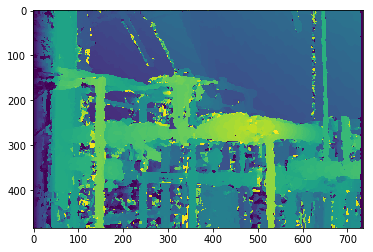

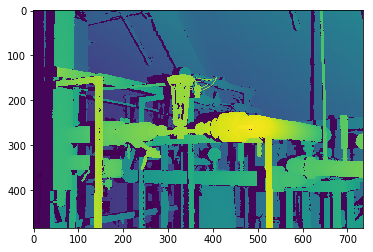

float64 int32
0.340543513543


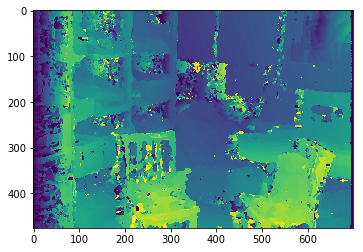

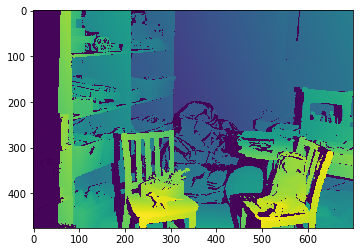

float64 int32
0.339743996951


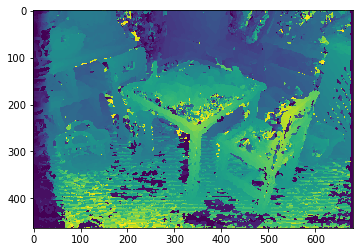

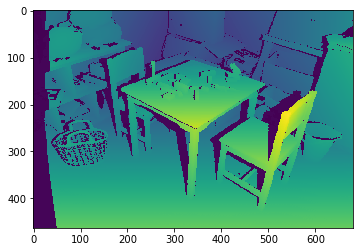

float64 int32
0.497213648834


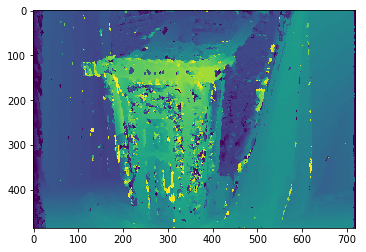

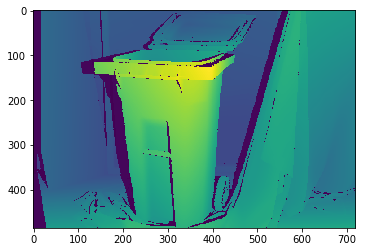

float64 int32
0.31534464238


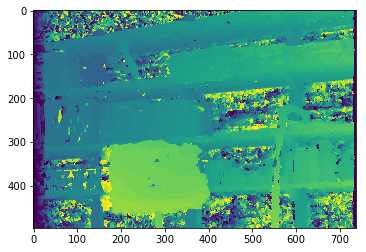

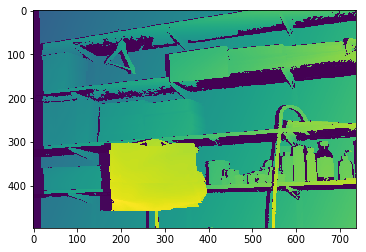

float64 int32
0.563543703704


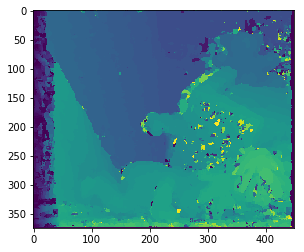

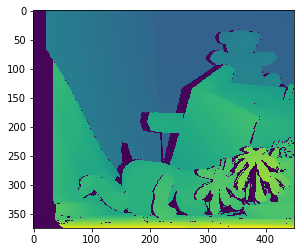

In [3]:
#%%time

def im2col(A, BSZ, stepsize=1):
    # Parameters
    M,N = A.shape
    col_extent = N - BSZ[1] + 1
    row_extent = M - BSZ[0] + 1

    # Get Starting block indices
    start_idx = np.arange(BSZ[0])[:,None]*N + np.arange(BSZ[1])

    # Get offsetted indices across the height and width of input array
    offset_idx = np.arange(row_extent)[:,None]*N + np.arange(col_extent)

    # Get all actual indices & index into input array for final output
    return np.take (A,start_idx.ravel()[:,None] + offset_idx.ravel()[::stepsize])

radius = 3
diameter = 2*radius+1
def census_transform(img):
    if True:
        full_pairs = [((0,0),(int(i/diameter)-radius,i%diameter-radius)) for i in range(diameter*diameter)]
        pairs = [x for idx,x in enumerate(full_pairs) if idx%2==0 and x != ((0,0),(0,0))]
        imgp = np.pad(np.sum(img,2).astype(np.int),radius,'edge')
        res = np.zeros((img.shape[0],img.shape[1],len(pairs)),np.int)
        l_comp = [p[0] for p in pairs]
        r_comp = [p[1] for p in pairs]
        l_comp_x = np.array([x[0] for x in l_comp])
        l_comp_y = np.array([x[1] for x in l_comp])
        r_comp_x = np.array([x[0] for x in r_comp])
        r_comp_y = np.array([x[1] for x in r_comp])
        for y in xrange(radius,img.shape[0]-radius-1):
            for x in xrange(radius,img.shape[1]-radius-1):
                p1 = imgp[l_comp_y + y,l_comp_x + x]
                p2 = imgp[r_comp_y + y,r_comp_x + x]
                res[y,x,:] = p1 > p2
        return res,np.sum(img,2).reshape([img.shape[0],img.shape[1],1])
    else:
        pairs = [i for i in range(diameter*diameter) if i%2 == 0 and i != (diameter*diameter-1)/2]
        imgp = np.pad(np.sum(img,2).astype(np.int),radius,'edge')
        #i2m = im2col(imgp,[diameter,diameter])
        p12 = i2m > i2m[(diameter*diameter-1)/2,:]
        cen = p12[pairs,:].T
        cen = cen.reshape([img.shape[0],img.shape[1],len(pairs)])
        #i2m.T is already "block" of size diameter*diameter
        return cen, np.sum(img,2).reshape([img.shape[0],img.shape[1],1])
def census_match(left,right,max_disp):
    lc,labs = census_transform(left)
    rc,rabs = census_transform(right)

    x_idx = np.array([(x-np.arange(max_disp)).clip(0) for x in xrange(lc.shape[1])])
    #i_idx = np.array([ x-np.zeros(max_disp,dtype=np.int) for x in xrange(lc.shape[1])])
   
    costs = np.zeros([lc.shape[0],lc.shape[1],max_disp])
    abs_costs = np.zeros([lc.shape[0],lc.shape[1],max_disp])

    for y in xrange(lc.shape[0]):
        for x in xrange(lc.shape[1]):
            abs_costs[y,x,:] = np.sqrt(np.sum((labs[y,x,:] - rabs[y,x_idx[x],:])**2,1))
            costs[y,x,:] = np.sum(lc[y,x,:] != rc[y,x_idx[x],:],1)
    return costs,abs_costs


i = 0
for image in os.listdir(DATASET_FOLDER): #
    fold_path = os.path.join(DATASET_FOLDER,image)
    gt_file = os.path.join(fold_path,'disp0GT.pfm')
    l_file = os.path.join(fold_path,'im0.png')
    r_file = os.path.join(fold_path,'im1.png')
    mask_file = os.path.join(fold_path,'mask0nocc.png')
    calib_file = os.path.join(fold_path,'calib.txt')

    if os.path.exists(gt_file):
        l = np.array(Image.open(l_file))
        r = np.array(Image.open(r_file))
        gt = load_pfm(gt_file)[0]
        mask = np.array(Image.open(mask_file))
        gt[np.where(mask == 128)] = -1
        gt[np.where(mask == 0)] = -2
        with open(calib_file) as fp:
            calib = {x.split('=')[0]:'='.join(x.split('=')[1:]) for x in fp.readlines()}
        if True:
            costs,abs_costs = census_match(l,r,int(calib['ndisp']))
            box_costs = (filters.uniform_filter(costs,[7,7,1],mode='nearest')*(7*7)).astype(np.int)
            print costs.dtype,box_costs.dtype
            box_costs_a = (filters.uniform_filter(abs_costs,[7,7,1],mode='nearest')*(7*7)).astype(np.int)
            if True:
                np.save('b2{0}.npy'.format(i),costs)
                np.save('a2{0}.npy'.format(i),abs_costs)
                np.save('g{0}.npy'.format(i),gt)
                np.save('l{0}.npy'.format(i),l)

                i+=1
            best = np.argmin(box_costs,2)
            print float((best == np.round(gt)).sum())/(gt.shape[0]*gt.shape[1])
            plt.imshow(best)
            plt.figure()
            plt.imshow(gt)
            plt.show()  

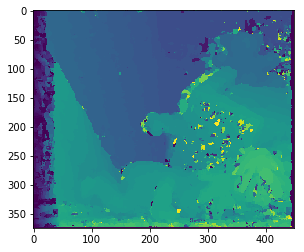

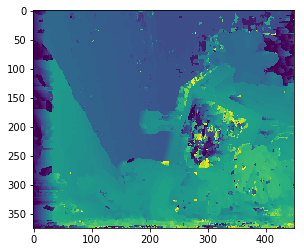

Wall time: 9.36 s


In [13]:
%%time
costs,abs_costs = census_match(l,r,int(calib['ndisp']))
box_costs = (filters.uniform_filter(costs,[7,7,1],mode='nearest')*(7*7)).astype(np.int)
best = np.argmin(box_costs,2)
plt.imshow(best)
plt.figure()
box_costs = (filters.uniform_filter(abs_costs,[7,7,1],mode='nearest')*(7*7)).astype(np.int)
best = np.argmin(box_costs,2)
plt.imshow(best)
plt.show()